<a href="https://colab.research.google.com/github/MujeebShinwari/Classification-Using-ViT-EfficientNet-and-ResNet-Models-on-Fundus_CIMT_Dataset/blob/main/Classification_Using_ViT%2C_EfficientNet%2C_and_ResNet_Models_on_Fundus_CIMT_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



**Install Dependencies**



In [1]:
# ✅ Install Dependencies
!pip install -q timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.8 MB/s eta 0:00:00


In [2]:
# ✅ Imports
import os, shutil, json, random
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import timm


In [3]:
# ✅ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/Fundus_CIMT_2903_Dataset'
json_path = os.path.join(base_path, 'data_info.json')
image_dir = os.path.join(base_path, 'data')


Mounted at /content/drive


In [4]:
# ✅ Load and Parse JSON File
with open(json_path) as f:
    raw = json.load(f)

records = []
for k, v in raw.items():
    for eye in ['left_eye', 'right_eye']:
        if v[eye] and os.path.exists(os.path.join(image_dir, v[eye])):
            records.append({
                'filename': v[eye],
                'label': int(v['label']),
                'thickness': v['thickness'],
                'true_age': v['True_age'],
                'age_norm': v['age'],
                'gender': v['gender']
            })

df = pd.DataFrame(records)
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
df.head()


,filename,label,thickness,true_age,age_norm,gender
0,200680003_R.png,1,0.9,38,0.342466,1
1,513810002_L.png,1,1.0,35,0.301370,1
2,549118001_L.png,0,0.8,22,0.123288,0
3,580761001_L.png,0,0.7,33,0.273973,1
4,640295001_R.png,0,0.7,23,0.136986,0


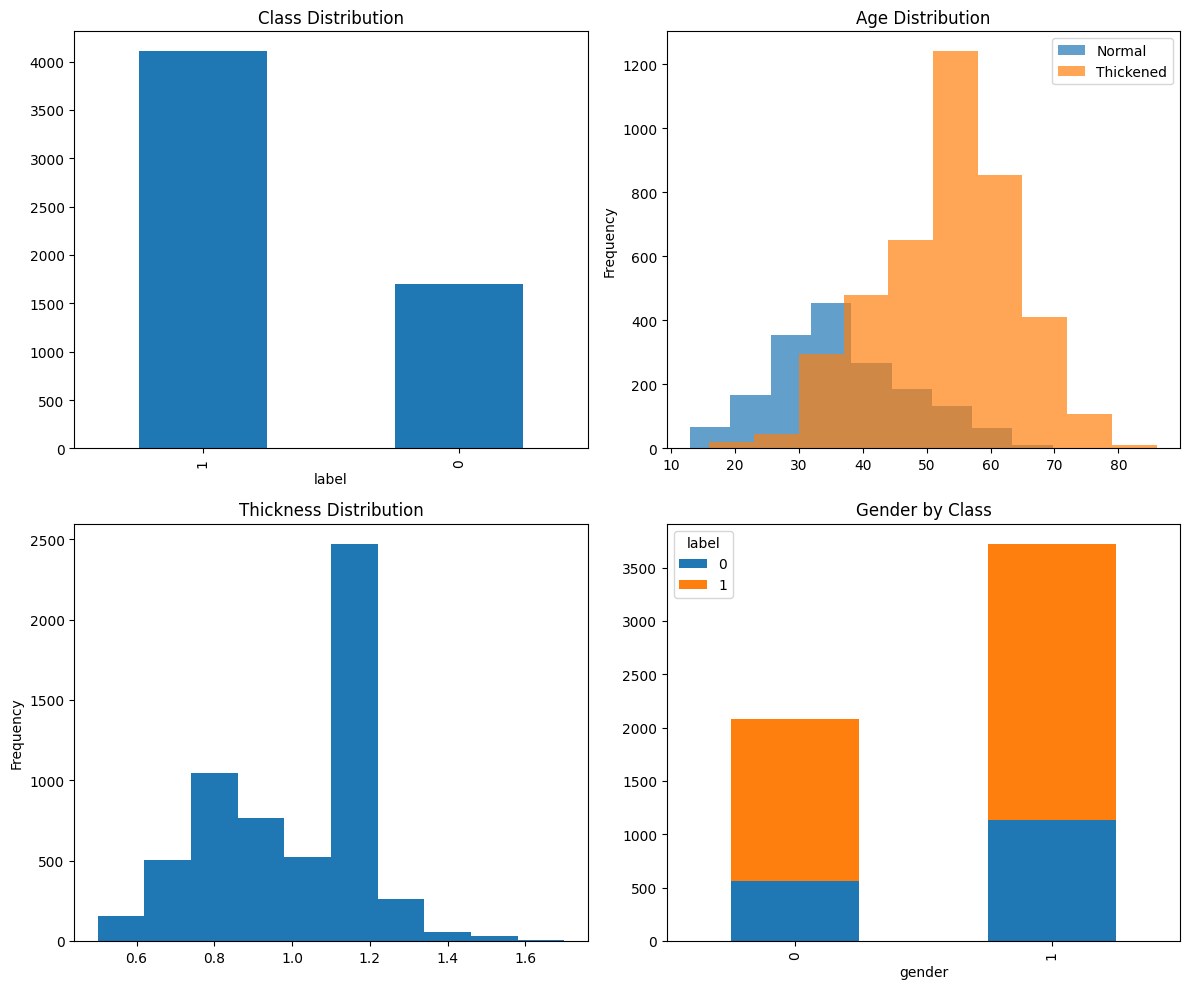

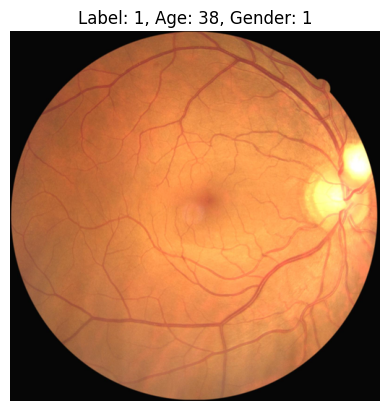

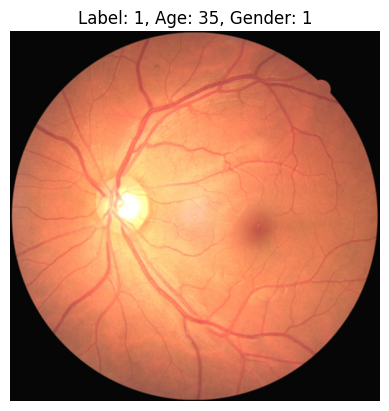

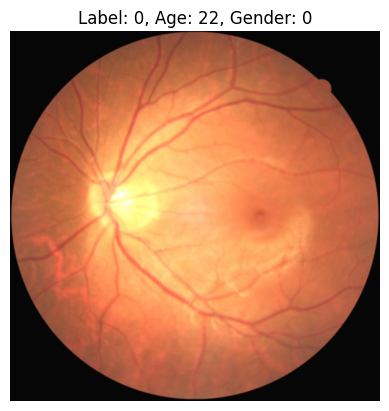

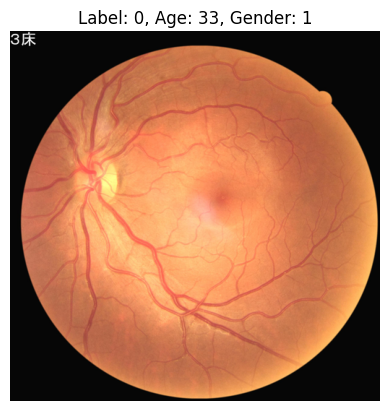

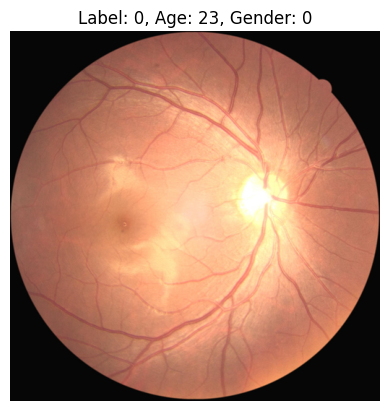

In [5]:
# ✅ Visualizations
fig, axs = plt.subplots(2, 2, figsize=(12,10))

df['label'].value_counts().plot(kind='bar', ax=axs[0,0], title='Class Distribution')
df[df['label']==0]['true_age'].plot(kind='hist', ax=axs[0,1], alpha=0.7, label='Normal', title='Age Distribution')
df[df['label']==1]['true_age'].plot(kind='hist', ax=axs[0,1], alpha=0.7, label='Thickened')
axs[0,1].legend()
df['thickness'].plot(kind='hist', ax=axs[1,0], title='Thickness Distribution')
pd.crosstab(df['gender'], df['label']).plot(kind='bar', stacked=True, ax=axs[1,1], title='Gender by Class')

plt.tight_layout()
plt.show()

# Display a few sample images
for i in range(5):
    img_path = os.path.join(image_dir, df.iloc[i]['filename'])
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"Label: {df.iloc[i]['label']}, Age: {df.iloc[i]['true_age']}, Gender: {df.iloc[i]['gender']}")
    plt.axis('off')
    plt.show()


<ipython-input-6-821e47bd8612>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette="Set2")


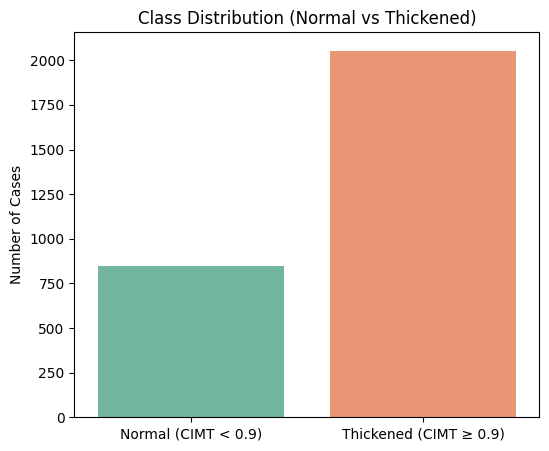

In [6]:
#Class Distribution (Normal vs Thickened)

import matplotlib.pyplot as plt
import seaborn as sns

labels = ['Normal (CIMT < 0.9)', 'Thickened (CIMT ≥ 0.9)']
counts = [849, 2054]

plt.figure(figsize=(6,5))
sns.barplot(x=labels, y=counts, palette="Set2")
plt.title("Class Distribution (Normal vs Thickened)")
plt.ylabel("Number of Cases")
plt.show()


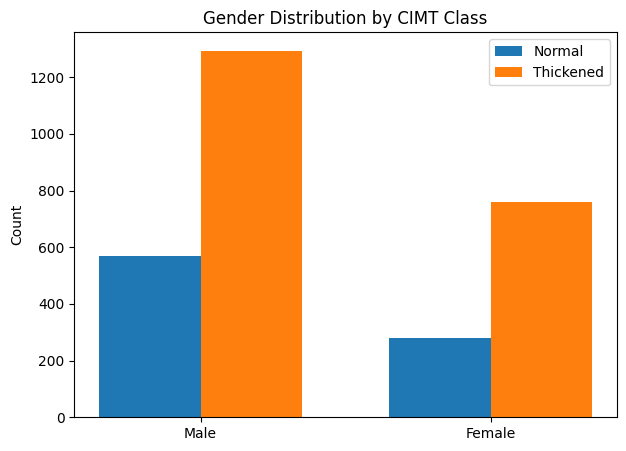

In [7]:
# Gender Destribution by class

import numpy as np

labels = ['Male', 'Female']
normal = [568, 281]
thickened = [1294, 760]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(7,5))
rects1 = ax.bar(x - width/2, normal, width, label='Normal')
rects2 = ax.bar(x + width/2, thickened, width, label='Thickened')

ax.set_ylabel('Count')
ax.set_title('Gender Distribution by CIMT Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


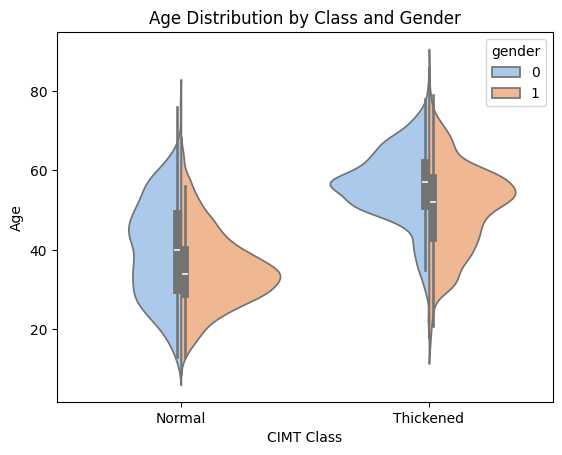

In [9]:
#Age Distribution by Class and Gender (Violin Plot or Boxplot)
sns.violinplot(data=df, x='label', y='true_age', hue='gender', split=True, palette='pastel')
plt.xticks([0, 1], ['Normal', 'Thickened'])
plt.title("Age Distribution by Class and Gender")
plt.ylabel("Age")
plt.xlabel("CIMT Class")
plt.show()


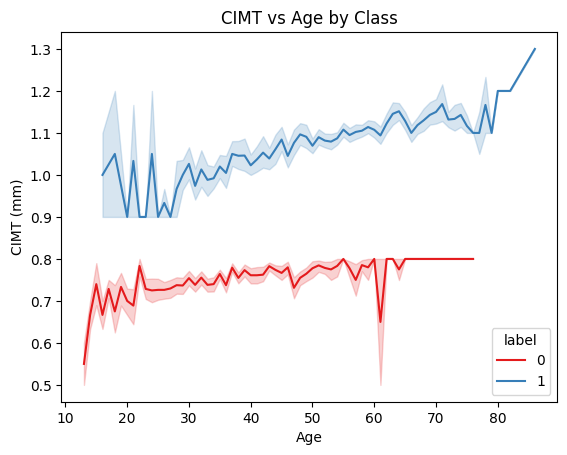

In [11]:
# CIMT Distribution with Age (Heatmap or Lineplot)
# Assuming df['age_bin'] = pd.cut(df['True_age'], bins=[30,40,50,60,70,80])
sns.lineplot(data=df, x='true_age', y='thickness', hue='label', palette='Set1')
plt.title("CIMT vs Age by Class")
plt.ylabel("CIMT (mm)")
plt.xlabel("Age")
plt.show()


In [14]:
# ✅  Create sample (10%) and split to train/test
df_sample = df.sample(frac=0.1, random_state=42)  # Change to df.copy() for full dataset
train_df, test_df = train_test_split(df_sample, test_size=0.2, stratify=df_sample['label'], random_state=42)

def organize_data(dataframe, split):
    for i, row in dataframe.iterrows():
        label_folder = 'normal' if row['label'] == 0 else 'disease'
        dest_dir = f'/content/data/{split}/{label_folder}'
        os.makedirs(dest_dir, exist_ok=True)
        src = os.path.join(image_dir, row['filename'])
        dst = os.path.join(dest_dir, row['filename'])
        if not os.path.exists(dst):
            shutil.copy(src, dst)

organize_data(train_df, 'train')
organize_data(test_df, 'test')


In [15]:
# ✅  Dataset and Dataloaders
class FundusDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        for label, folder in enumerate(['normal', 'disease']):
            folder_path = os.path.join(root_dir, folder)
            for fname in os.listdir(folder_path):
                self.samples.append((os.path.join(folder_path, fname), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_ds = FundusDataset('/content/data/train', transform)
test_ds = FundusDataset('/content/data/test', transform)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)


In [28]:
# ✅ Training Function
def train_model(model, epochs=50):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()
    accs, aucs, losses = [], [], []

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.float().to(device)
            out = model(xb).squeeze(1)
            loss = criterion(out, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        all_y, all_p = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(device)
                preds = model(xb).squeeze(1)
                probs = torch.sigmoid(preds).cpu()
                all_y.extend(yb.numpy())
                all_p.extend(probs.numpy())

        pred_bin = [1 if p > 0.5 else 0 for p in all_p]
        acc = accuracy_score(all_y, pred_bin)
        auc = roc_auc_score(all_y, all_p)
        accs.append(acc)
        aucs.append(auc)
        losses.append(loss.item())
        print(f"Epoch {epoch+1}: Acc={acc:.4f}, AUC={auc:.4f}, Loss={loss.item():.4f}")

    return accs, aucs, losses


In [29]:
# ✅ Model Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=1)
eff = timm.create_model('efficientnet_b0', pretrained=True, num_classes=1)
resnet = models.resnet50(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, 1)

print("Training ViT...")
vit_results = train_model(vit)

print("Training EfficientNet...")
eff_results = train_model(eff)

print("Training ResNet...")
resnet_results = train_model(resnet)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training ViT...
Epoch 1: Acc=0.7094, AUC=0.6846, Loss=0.6306
Epoch 2: Acc=0.7094, AUC=0.6488, Loss=0.6425
Epoch 3: Acc=0.7094, AUC=0.6797, Loss=0.5832
Epoch 4: Acc=0.7094, AUC=0.7006, Loss=0.7216
Epoch 5: Acc=0.7094, AUC=0.6807, Loss=0.7652
Epoch 6: Acc=0.7094, AUC=0.7052, Loss=0.5290
Epoch 7: Acc=0.7094, AUC=0.7080, Loss=0.6048
Epoch 8: Acc=0.7094, AUC=0.6648, Loss=0.5598
Epoch 9: Acc=0.7094, AUC=0.7023, Loss=0.6639
Epoch 10: Acc=0.7094, AUC=0.6977, Loss=0.6111
Epoch 11: Acc=0.7094, AUC=0.6917, Loss=0.4797
Epoch 12: Acc=0.7094, AUC=0.6871, Loss=0.4735
Epoch 13: Acc=0.7094, AUC=0.6949, Loss=0.6216
Epoch 14: Acc=0.7094, AUC=0.6999, Loss=0.3808
Epoch 15: Acc=0.7094, AUC=0.7147, Loss=0.6200
Epoch 16: Acc=0.7094, AUC=0.6715, Loss=0.4463
Epoch 17: Acc=0.7094, AUC=0.6573, Loss=0.5793
Epoch 18: Acc=0.7094, AUC=0.6623, Loss=0.7172
Epoch 19: Acc=0.6239, AUC=0.6609, Loss=0.6536
Epoch 20: Acc=0.7265, AUC=0.7048, Loss=0.5768
Epoch 21: Acc=0.7094, AUC=0.6928, Loss=0.5341
Epoch 22: Acc=0.7179, AUC=0

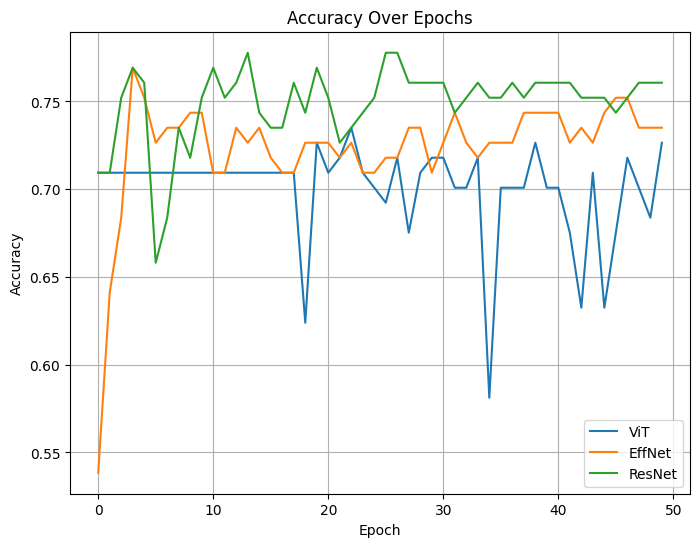

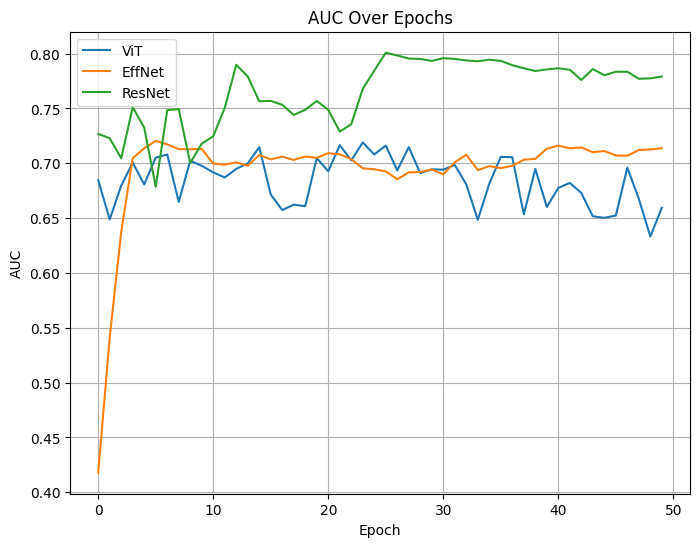

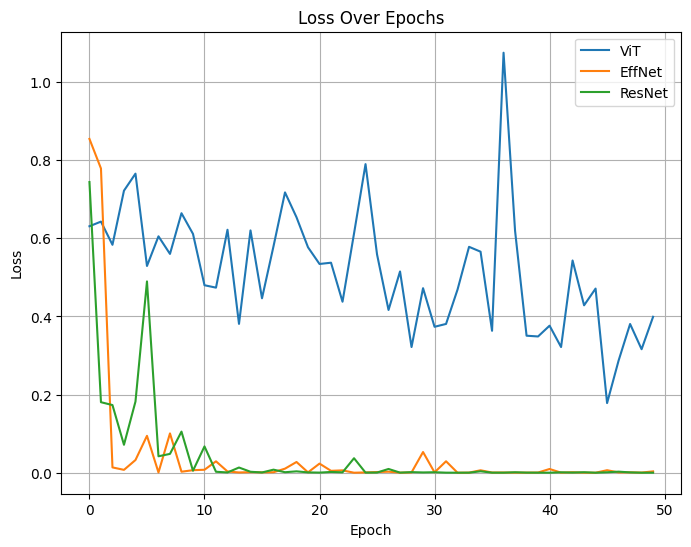

In [30]:
# ✅ Plot Accuracy, AUC, Loss
def plot_metric(metric_list, title, ylabel):
    plt.figure(figsize=(8,6))
    plt.plot(metric_list[0], label='ViT')
    plt.plot(metric_list[1], label='EffNet')
    plt.plot(metric_list[2], label='ResNet')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric([vit_results[0], eff_results[0], resnet_results[0]], "Accuracy Over Epochs", "Accuracy")
plot_metric([vit_results[1], eff_results[1], resnet_results[1]], "AUC Over Epochs", "AUC")
plot_metric([vit_results[2], eff_results[2], resnet_results[2]], "Loss Over Epochs", "Loss")


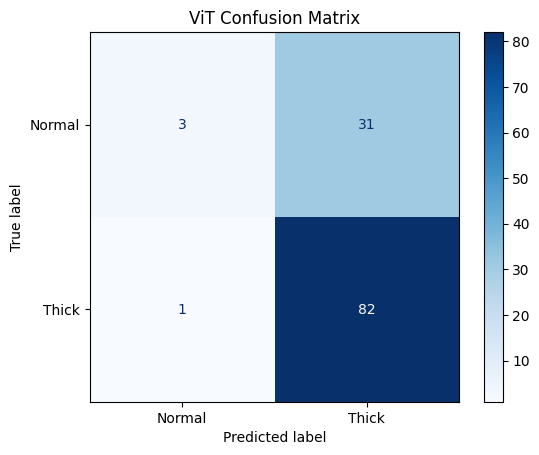

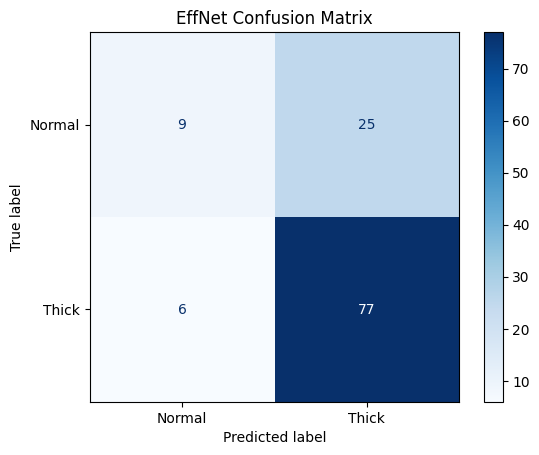

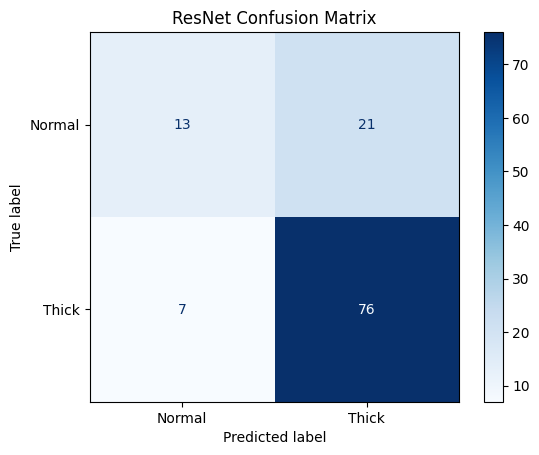

In [31]:
# ✅ Confusion Matrices
def show_conf_matrix(model, title):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits = model(xb).squeeze(1)
            preds = (torch.sigmoid(logits) > 0.5).int().cpu()
            y_true.extend(yb)
            y_pred.extend(preds)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Thick'])
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.show()

show_conf_matrix(vit, "ViT Confusion Matrix")
show_conf_matrix(eff, "EffNet Confusion Matrix")
show_conf_matrix(resnet, "ResNet Confusion Matrix")


**Common Setup Cell**

In [22]:
# 📦 Import libraries
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files

# 🏷️ Class names
class_names = ['Normal (CIMT < 0.9 mm)', 'Disease (CIMT ≥ 0.9 mm)']

# 🔄 Image preprocessing (adjust to match your training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # or your actual training input size
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# 📊 Function to display prediction
def show_prediction(img_path, prediction, confidence):
    img = Image.open(img_path).convert("RGB")
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {class_names[prediction]} (Confidence: {confidence:.2f}%)")
    plt.show()


**Classify with RetFound Model**

In [26]:
# ⬆️ Upload image
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# 🔽 Load RetFound model
#retfound_model = torch.load(vit, map_location=torch.device('cpu'))
retfound_model = vit
retfound_model.eval()

# 🖼️ Process image
img = Image.open(img_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0)

# 🔍 Predict
with torch.no_grad():
    output = retfound_model(input_tensor)
    prob = torch.softmax(output, dim=1)
    confidence, pred_class = torch.max(prob, 1)

# 🖼️ Show result
show_prediction(img_path, pred_class.item(), confidence.item() * 100)


Saving 16669003_L.png to 16669003_L (3).png


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [27]:
# ⬆️ Upload image
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# 🔽 Load RetFound model
#retfound_model = torch.load(vit, map_location=torch.device('cpu'))
retfound_model = vit
retfound_model.eval()

# 🖼️ Process image
img = Image.open(img_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0)

# Move the input tensor to the same device as the model
input_tensor = input_tensor.to(device)

# 🔍 Predict
with torch.no_grad():
    output = retfound_model(input_tensor)
    # Note: The ViT model for binary classification outputs a single value,
    # so using softmax with dim=1 might not be appropriate here.
    # It's better to apply sigmoid for binary classification output.
    prob = torch.sigmoid(output) # Apply sigmoid for binary output
    # Since it's binary classification with a single output,
    # confidence is the probability of the positive class (index 1)
    confidence = prob.squeeze().item() # Get the probability of the positive class
    pred_class = (confidence > 0.5).int().item() # Get the predicted class (0 or 1)

# 🖼️ Show result
# Pass the single probability value for confidence, and the predicted class
show_prediction(img_path, pred_class, confidence * 100)

Saving 16669003_L.png to 16669003_L (4).png


AttributeError: 'bool' object has no attribute 'int'

**Classify with Vision Transformer (ViT) Mode**

In [ ]:
# ⬆️ Upload image
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# 🔽 Load ViT model
vit_model = torch.load("vit_model.pth", map_location=torch.device('cpu'))
vit_model.eval()

# 🖼️ Process image
img = Image.open(img_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0)

# 🔍 Predict
with torch.no_grad():
    output = vit_model(input_tensor)
    prob = torch.softmax(output, dim=1)
    confidence, pred_class = torch.max(prob, 1)

# 🖼️ Show result
show_prediction(img_path, pred_class.item(), confidence.item() * 100)


**Classify with EfficientNetV2 Model**

In [ ]:
# ⬆️ Upload image
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# 🔽 Load EfficientNetV2 model
efficientnet_model = torch.load("efficientnet_model.pth", map_location=torch.device('cpu'))
efficientnet_model.eval()

# 🖼️ Process image
img = Image.open(img_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0)

# 🔍 Predict
with torch.no_grad():
    output = efficientnet_model(input_tensor)
    prob = torch.softmax(output, dim=1)
    confidence, pred_class = torch.max(prob, 1)

# 🖼️ Show result
show_prediction(img_path, pred_class.item(), confidence.item() * 100)
